In [ ]:
from matplotlib import pyplot as plt
import tensorflow as tf

import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import losses
from imageio import imread
from glob import glob

import pickle
from tqdm import tqdm
import numpy as np
import os

# Training an Autoencoder Network to Learn a Latent Representation of Face Images  

In [ ]:
# Loading the images (currently with dummy path) 
PATH = "/dataset"
im_paths = glob(PATH+"/*")
data = []
for im_path in tqdm(im_paths):
    data.append(np.array(imread(im_path)/255))

100%|██████████| 1208/1208 [15:49<00:00,  1.27it/s]


In [ ]:
# Validating input images shape
data[0].shape

(256, 256, 3)

In [ ]:
# 90\10 train-test set split
x_train = np.reshape(data[:1100], (1100,256, 256, 3)).astype('float32')
x_test = np.reshape(data[1100:], (108, 256, 256, 3)).astype('float32') 


In [ ]:
# Defining the encoder network architecture 
latent_dim = 1800
encoder = Sequential()
encoder.add(layers.Conv2D(256, (4, 4), strides=(2, 2), activation='relu', padding='same', input_shape=(256, 256, 3)))
encoder.add(layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same'))
encoder.add(layers.Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same'))
encoder.add(layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))
encoder.add(layers.Conv2D(96, (3, 3), strides=(2, 2), activation='relu', padding='same'))
encoder.add(layers.Reshape((8 * 8 * 96,)))
encoder.add(layers.Dense(latent_dim))

# Defining the decoder network architecture
decoder = Sequential()
decoder.add(layers.Dense(16 * 16 * 96, activation='relu', input_shape=(latent_dim,)))
decoder.add(layers.Reshape((16,16,96)))
decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same'))
decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same'))
decoder.add(layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), activation='relu', padding='same'))
decoder.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), activation='sigmoid', padding='same'))

# Combining them into an auto-encoder network
autoencoder = keras.Model(encoder.inputs, decoder(encoder.outputs))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# Fitting the model 
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=20,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[cp_callback])
# Getting the test set result imges and latent vectors
decoded_imgs = autoencoder.predict(x_test)
latent_codes = encoder.predict(x_test)


Epoch 1/100
55/55 [==============================] - 17s 286ms/step - loss: 0.5431 - val_loss: 0.4082
Epoch 2/100
55/55 [==============================] - 15s 280ms/step - loss: 0.3946 - val_loss: 0.3894
Epoch 3/100
55/55 [==============================] - 15s 279ms/step - loss: 0.3790 - val_loss: 0.3514
Epoch 4/100
55/55 [==============================] - 15s 279ms/step - loss: 0.3458 - val_loss: 0.3428
Epoch 5/100
55/55 [==============================] - 15s 278ms/step - loss: 0.3382 - val_loss: 0.3334
Epoch 6/100
55/55 [==============================] - 15s 278ms/step - loss: 0.3334 - val_loss: 0.3329
Epoch 7/100
55/55 [==============================] - 15s 278ms/step - loss: 0.3304 - val_loss: 0.3299
Epoch 8/100
55/55 [==============================] - 15s 276ms/step - loss: 0.3259 - val_loss: 0.3270
Epoch 9/100
55/55 [==============================] - 15s 278ms/step - loss: 0.3265 - val_loss: 0.3269
Epoch 10/100
55/55 [==============================] - 15s 277ms/step - loss: 0.325

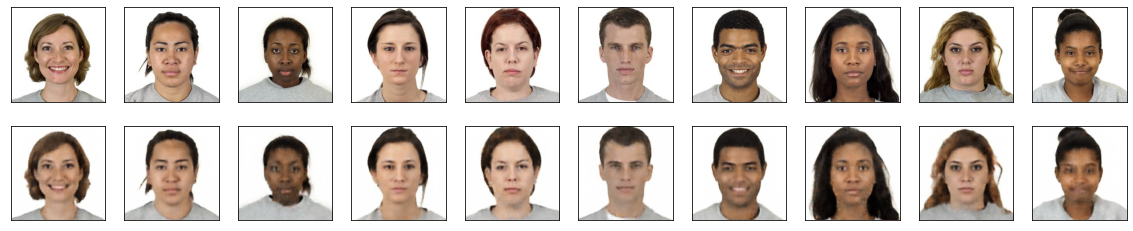

In [ ]:
# Plotting 10 original and decoded examples from the test set
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ind =np.random.randint(107)
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[ind].reshape(256, 256,3))

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[ind].reshape(256, 256,3))

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Saving the models
encoder.save("models/enc.h5")
decoder.save("models/dec.h5")
autoencoder.save("models/auto.h5")